In [17]:
import pandas as pd

df_pha = pd.read_csv('datasets/Psychosocial_Health_Analysis.csv')
df_pha['problem_category'] = df_pha['problem_category'].str.lower().str.strip()
df_pha['psychological_catehory'] = df_pha['psychological_catehory'].str.lower().str.strip()

df_pha = df_pha[
    (df_pha['problem_category'] == 'stress') | 
    (df_pha['problem_category'] == 'anxiety') |
    (df_pha['psychological_catehory'] == 'stress') |
    (df_pha['psychological_catehory'] == 'anxiety')
    ]

df_pha['label'] = 1
df_pha = df_pha.rename(columns={'Problem_description': 'text'})

df_pha = df_pha.drop(['Age', 'Gender', 'problem_summary', 'problem_category', 'psychological_catehory'], axis=1)

df_pha.head()

,text,label
0,A woman is sharing their challenges as the on...,1
3,"How to increase confidence? Feeling insecure, ...",1
5,"The user is in a complicated situation, caught...",1
6,The user was previously in a relationship but ...,1
8,The user is experiencing emotional turmoil due...,1


In [2]:
df_stress = pd.read_csv('datasets/Stress.csv')

df_stress = df_stress.drop(['subreddit','post_id','sentence_range','confidence','social_timestamp'], axis=1)

df_stress.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [3]:
df_mhc = pd.read_csv('datasets/NLP_Mental_Health_Conversations.csv')

df_mhc['label'] = 1
df_mhc = df_mhc.rename(columns={'Context': 'text'})

df_mhc = df_mhc.drop('Response', axis=1)
df_mhc = df_mhc.drop_duplicates()

df_mhc.head()

,text,label
0,I'm going through some things with my feelings...,1
23,I have so many issues to address. I have a his...,1
70,I have been feeling more and more down for ove...,1
72,I’m facing severe depression and anxiety and I...,1
81,How can I get to a place where I can be conten...,1


In [4]:
# Read in reddit posts from subreddits that are deemed positive. Note: Some datasets are too large, and are split into parts instead.
import re

filepaths = [
    ("datasets/reddit/MadeMeSmile_submissions00.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions01.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions02.zip", 90),
    ("datasets/reddit/MadeMeSmile_submissions03.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions04.zip", 90),    
    ("datasets/reddit/MadeMeSmile_submissions05.zip", 90),
    ("datasets/reddit/wholesome_submissions.zip", 600)    
]

df_positive = pd.DataFrame(columns=['selftext'])

for f in filepaths:
    df_temp = pd.read_json(f[0], lines=True)[['selftext']]
    df_temp['selftext'] = df_temp['selftext'].apply(lambda x: re.sub(r'http\S+', '', x))
    df_temp = df_temp[
        (df_temp['selftext'] != '') & 
        (df_temp['selftext'] != '[deleted]') & 
        (df_temp['selftext'] != '[removed]') &
        (df_temp['selftext'].str.contains('removed by reddit', flags=re.IGNORECASE) == False) &
        (df_temp['selftext'].apply(lambda x: len(x.split()) >= 10))
    ].sample(f[1])

    df_positive = pd.concat([df_positive, df_temp], ignore_index=True)

df_positive = df_positive.reset_index(drop=True)

df_positive['label'] = 0
df_positive = df_positive.rename(columns={'selftext' : 'text'})

df_positive.head()

,text,label
0,I didn’t even ask for it but it was a really p...,0
1,Again idk i just love my pupper. Im laying on ...,0
2,what are things you all like to do to cheer yo...,0
3,Below is a comment that was left on a video ti...,0
4,"On our way back, we saw a man and his approxim...",0


In [5]:
# Combine all datasets into a single dataframe
df = pd.concat([df_pha, df_stress, df_mhc, df_positive], ignore_index=True)
#df = df_stress
df = df.reset_index(drop=True)

df.head()

,text,label
0,A woman is sharing their challenges as the on...,1
1,"How to increase confidence? Feeling insecure, ...",1
2,"The user is in a complicated situation, caught...",1
3,The user was previously in a relationship but ...,1
4,The user is experiencing emotional turmoil due...,1


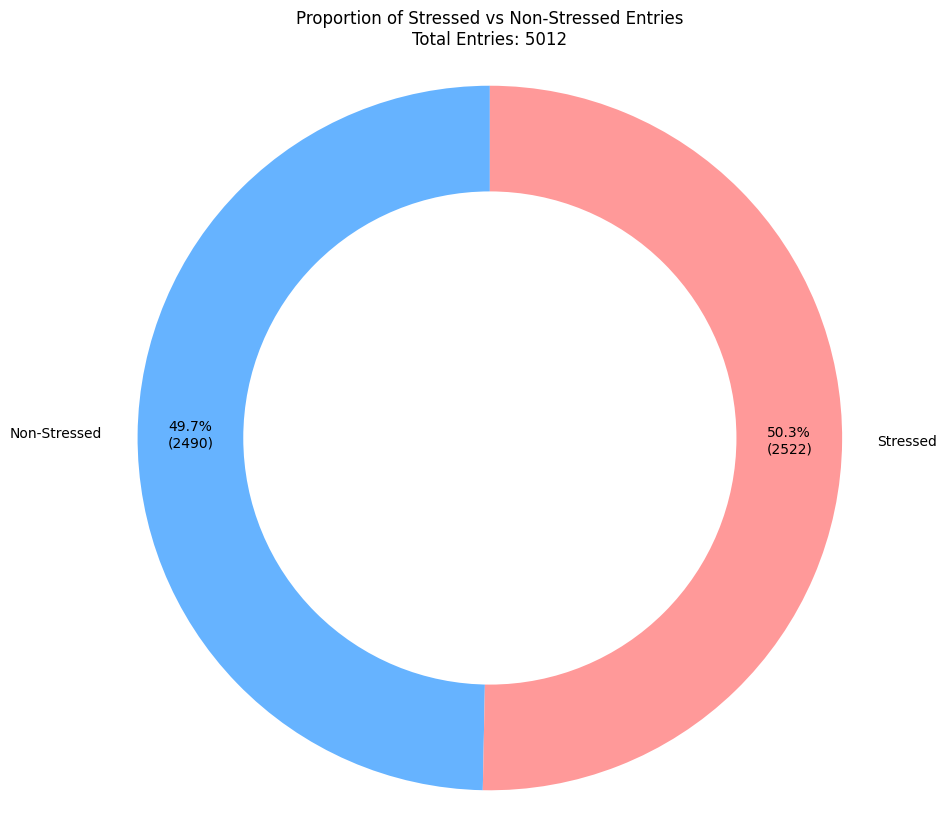

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

label_counts = df['label'].value_counts()

labels = ['Non-Stressed', 'Stressed']

if 0 in label_counts and 1 in label_counts:
    counts = [label_counts[0], label_counts[1]]
    total_entries = label_counts.sum()
else:
    counts = [0, 0]  
    total_entries = 0

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

colors = ['#66b3ff', '#ff9999']

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(counts, labels=labels, colors=colors, autopct=lambda pct: func(pct, counts),
       startangle=90, pctdistance=0.85)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')

plt.title(f'Proportion of Stressed vs Non-Stressed Entries\nTotal Entries: {total_entries}')
plt.show()


In [49]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))

[nltk_data] Downloading package omw-1.4 to /home/brian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [50]:
# Clean up and lemmatize the texts.

def process_texts(text):

    # Strip and convert text to lower case
    text = text.strip().lower()

    # Remove urls
    text = re.sub(r'http\S+', '', text)
    
    # Remove escape characters
    text = re.sub(r'\@\w+', '', text)

    # Remove emojis
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)

    # Remove html tags 
    text = re.sub(r'<.*?>', '', text)
    
    # Remove new line in string form
    text = re.sub(r'\\n', '', text)

    # Replace brackets with space
    text = re.sub(r'[\]\[\)\(]', ' ', text)
    
    # Remove all characters except alphabets
    text = re.sub(r'[^A-Za-z]' ,' ', text)

    # Replace multiple whitespace with single space
    text = re.sub(r'\s\s+', ' ', text)

    # Tokenize the sentence
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [t for t in tokens if not t in stop_words]

    # POS tag the words
    pos = pos_tag(tokens)

    # Lemmatize all words
    text = []
    for word, tag in pos:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        text.append(lemmatizer.lemmatize(word, wntag) if wntag else word)

    # Remove single letter words
    for w in text:
        if len(w) <= 1:
            text.remove(w)

    return ' '.join(text)

df['processed_text'] = df['text'].apply(lambda x: process_texts(x))

df.sample(10)


,text,label,processed_text
4722,[Grandpa Reads the Comics]( gained some [popul...,0,grandpa read comic gain popularity reddit day ...
3891,This past year has rocked my family in more wa...,0,past year rock family way us think would grand...
2196,Today was a horrible day from the get go and I...,1,today horrible day get go call cant function p...
3344,"My boyfriend won't touch me intimately, he won...",1,boyfriend touch intimately kiss sex oral sex k...
3452,I have known I was always different. This year...,1,know always different year december find never...
3699,How does a person start the counseling process?,1,person start counseling process
599,When we were leaving that place the manager wa...,0,leave place manager attempt rush us get apartm...
3718,My dad refuses to acknowledge my anxieties abo...,1,dad refuse acknowledge anxiety go party dinner...
317,In his own ways I know he loves me but he's do...,1,way know love double body weight weight lifter...
2161,Which forced me to acknowledge that I haven’t ...,1,force acknowledge perform expectation enter an...


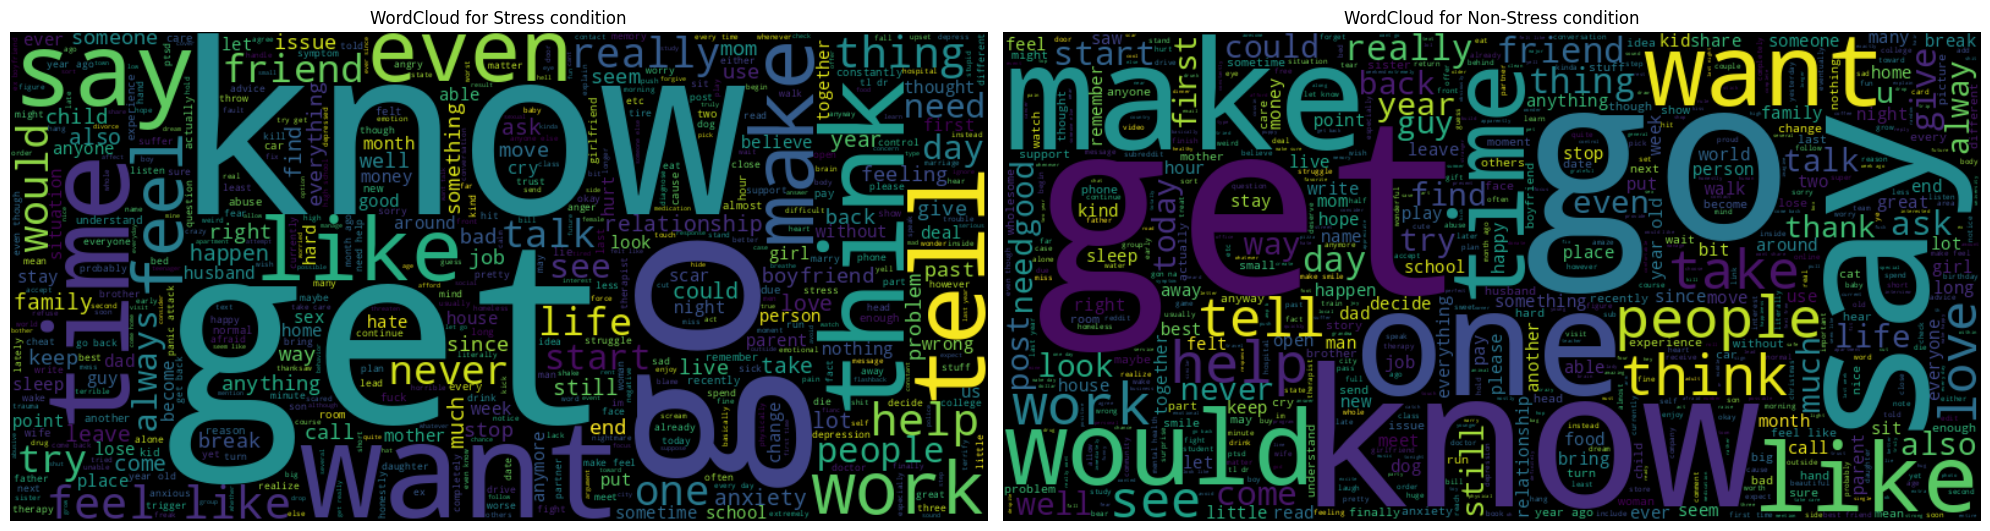

In [51]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

wc_stress = WordCloud(max_words=2000, width=800, height=400, stopwords=stop_words).generate(" ".join(df[df.label == 1].processed_text))
axs[0].imshow(wc_stress, interpolation='bilinear')
axs[0].set_title('WordCloud for Stress condition')
axs[0].axis('off') 

wc_non_stress = WordCloud(max_words=2000, width=800, height=400, stopwords=stop_words).generate(" ".join(df[df.label == 0].processed_text))
axs[1].imshow(wc_non_stress, interpolation='bilinear')
axs[1].set_title('WordCloud for Non-Stress condition')
axs[1].axis('off')  

plt.tight_layout()
plt.show()

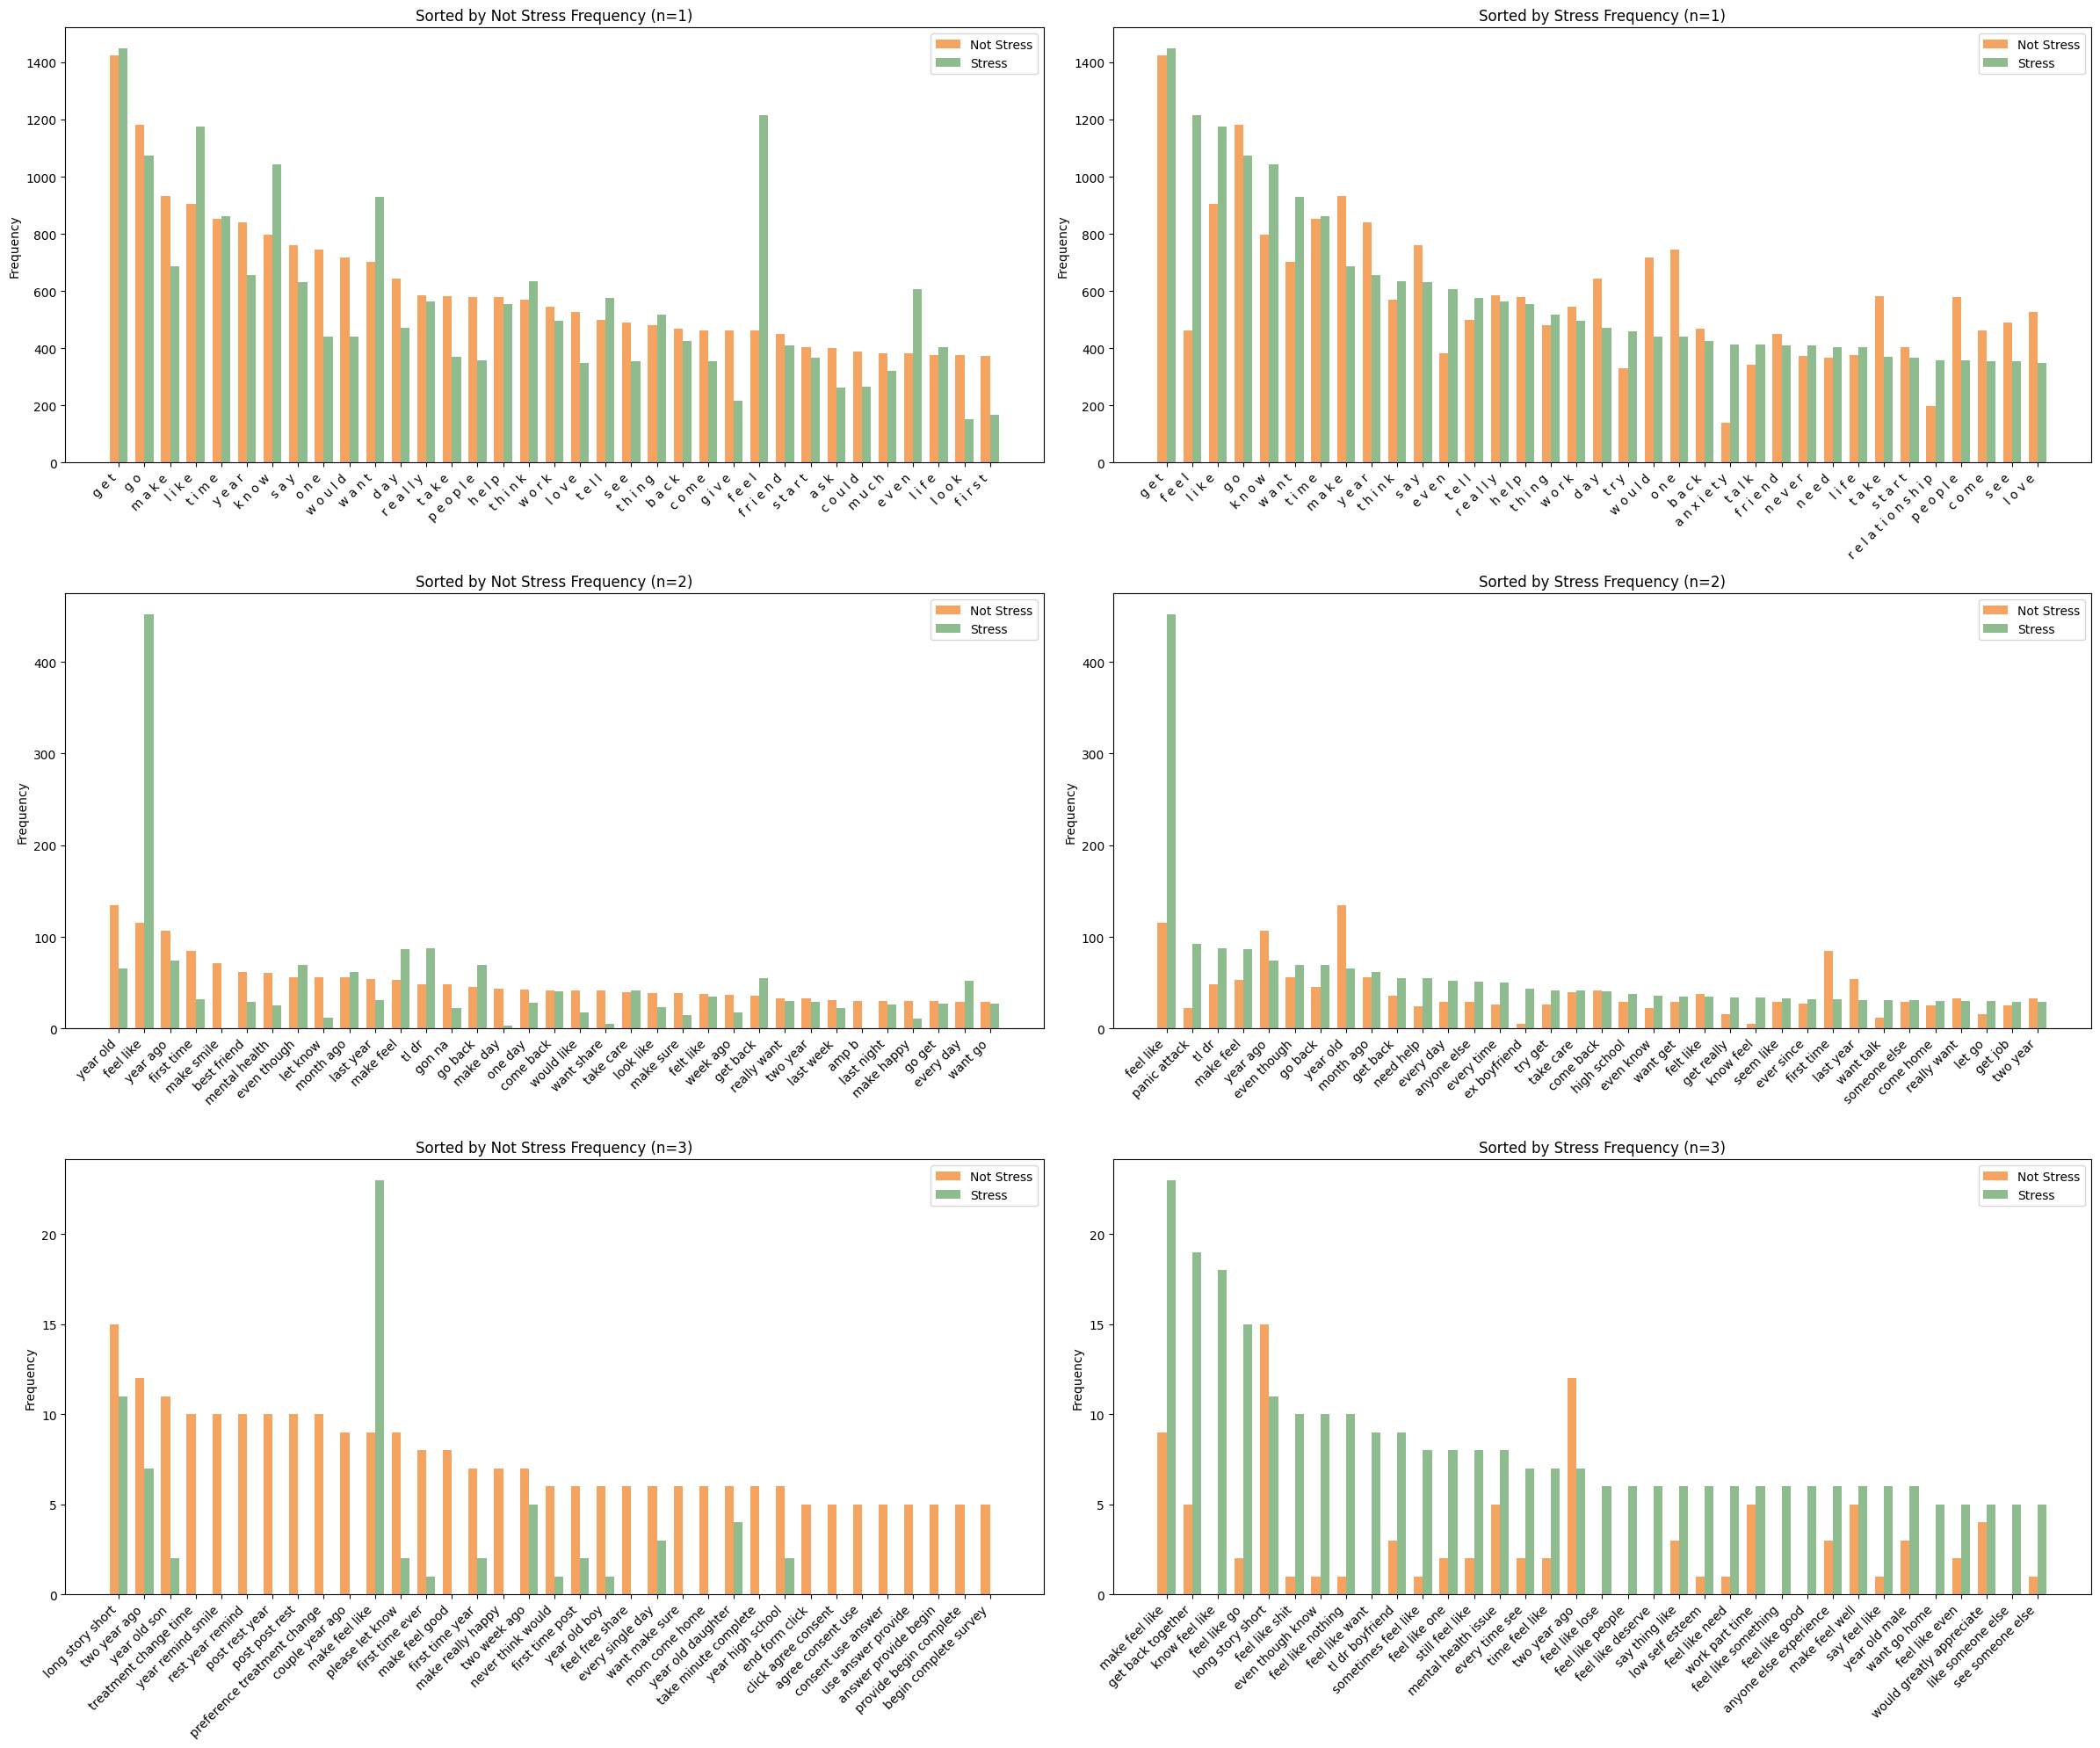

In [52]:
from nltk.util import bigrams, trigrams

# Helper function to get n-grams
def get_ngrams(text, n=1):
    tokens = word_tokenize(text.lower())
    if n == 1:
        return tokens  # Single words
    elif n == 2:
        return list(bigrams(tokens))
    elif n == 3:
        return list(trigrams(tokens))

# Generate and count n-grams frequencies
def count_ngrams(label, n=1):
    ngrams = df[df['label'] == label]['processed_text'].apply(get_ngrams, n=n).explode()
    return ngrams.value_counts().rename(f'label_{label}')

def plot_ngrams(ax, sorted_by_label_0, sorted_by_label_1, n=1):
    indices_0 = range(len(sorted_by_label_0))
    indices_1 = range(len(sorted_by_label_1))
    bar_width = 0.35

    ax[0].bar(indices_0, sorted_by_label_0[f'label_0'], width=bar_width, color='#f4a460', label='Not Stress')
    ax[0].bar([i+bar_width for i in indices_0], sorted_by_label_0[f'label_1'], width=bar_width, color='#8fbc8f', label='Stress')
    ax[0].set_title(f'Sorted by Not Stress Frequency (n={n})')
    ax[0].set_xticks([i + bar_width / 2 for i in indices_0])
    ax[0].set_xticklabels([' '.join(map(str, ngram)) for ngram in sorted_by_label_0.index], rotation=45, ha="right")

    ax[1].bar(indices_1, sorted_by_label_1[f'label_0'], width=bar_width, color='#f4a460', label='Not Stress')
    ax[1].bar([i+bar_width for i in indices_1], sorted_by_label_1[f'label_1'], width=bar_width, color='#8fbc8f', label='Stress')
    ax[1].set_title(f'Sorted by Stress Frequency (n={n})')
    ax[1].set_xticks([i + bar_width / 2 for i in indices_1])
    ax[1].set_xticklabels([' '.join(map(str, ngram)) for ngram in sorted_by_label_1.index], rotation=45, ha="right")

    for a in ax:
        a.set_ylabel('Frequency')
        a.legend()

# Setup the 2x3 grid of plots
fig, axs = plt.subplots(3, 2, figsize=(24, 20))

# Single-word frequencies
freqs_0_words = count_ngrams(0, n=1)
freqs_1_words = count_ngrams(1, n=1)
sorted_by_label_0_words = pd.concat([freqs_0_words, freqs_1_words], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(35)
sorted_by_label_1_words = pd.concat([freqs_0_words, freqs_1_words], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(35)
plot_ngrams(axs[0], sorted_by_label_0_words, sorted_by_label_1_words, n=1)

# Bigram frequencies
freqs_0_bigrams = count_ngrams(0, n=2)
freqs_1_bigrams = count_ngrams(1, n=2)
sorted_by_label_0_bigrams = pd.concat([freqs_0_bigrams, freqs_1_bigrams], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(35)
sorted_by_label_1_bigrams = pd.concat([freqs_0_bigrams, freqs_1_bigrams], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(35)
plot_ngrams(axs[1], sorted_by_label_0_bigrams, sorted_by_label_1_bigrams, n=2)

# Trigram frequencies
freqs_0_trigrams = count_ngrams(0, n=3)
freqs_1_trigrams = count_ngrams(1, n=3)
sorted_by_label_0_trigrams = pd.concat([freqs_0_trigrams, freqs_1_trigrams], axis=1).fillna(0).sort_values(by='label_0', ascending=False).head(35)
sorted_by_label_1_trigrams = pd.concat([freqs_0_trigrams, freqs_1_trigrams], axis=1).fillna(0).sort_values(by='label_1', ascending=False).head(35)
plot_ngrams(axs[2], sorted_by_label_0_trigrams, sorted_by_label_1_trigrams, n=3)

plt.tight_layout()
plt.show()

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Splitting the dataset
x_train, x_test, y_train, y_test = train_test_split(df['processed_text'], df['label'], stratify=df['label'], test_size=0.2, random_state=42)

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', LogisticRegression(max_iter=1000))  # Increased max_iter for convergence
])

# Parameters for GridSearchCV
param_grid = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],  # n-grams
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l2']
}

# GridSearchCV to find the best parameters
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# Best parameters and scores
print("Best parameters:", grid_search.best_params_)
print("Training accuracy:", grid_search.score(x_train, y_train))
print("Test accuracy:", grid_search.score(x_test, y_test))

# Classification report
y_pred = grid_search.predict(x_test)
print(classification_report(y_test, y_pred))

Best parameters: {'model__C': 1, 'model__penalty': 'l2', 'tfidf__max_df': 0.5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}
Training accuracy: 0.9358942379645797
Test accuracy: 0.8125623130608175
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       498
           1       0.82      0.80      0.81       505

    accuracy                           0.81      1003
   macro avg       0.81      0.81      0.81      1003
weighted avg       0.81      0.81      0.81      1003



In [54]:
def predict_stress(text):
    predicted_label = grid_search.predict([text])[0] 
    return predicted_label

In [63]:
df_sfu = pd.read_json('datasets/reddit/simonfraser_submissions.zip', lines=True)

df_sfu = df_sfu[['selftext', 'created']]
df_sfu = df_sfu.dropna()
df_sfu = df_sfu[df_sfu['selftext'].apply(lambda x: len(x.split()) >= 10)]

df_sfu['processed_text'] = df_sfu['selftext'].apply(lambda x : process_texts(x))
df_sfu = df_sfu[df_sfu['processed_text'].apply(lambda x: len(x.split()) >= 10)]

df_sfu['stress'] = df_sfu['processed_text'].apply(lambda x : predict_stress(x))

df_sfu['created'] = df_sfu['created'].astype(int)


df_sfu.sample(200)

,selftext,created,processed_text,stress
23328,"Hey, guys! This is my first semester at SFU, a...",1681529727,hey guy first semester sfu find amy informatio...,0
26607,"Hey, I'm new to cognitive science and I'm cont...",1700453995,hey new cognitive science contemplate major un...,0
1590,"Disclaimer: Yes, I know I was a retard for ski...",1439203692,disclaimer yes know retard skip much class exc...,1
1252,"I want to go international, but the advisor to...",1422423124,want go international advisor tell would reall...,0
24731,So I had some stuff occur recently and I’ve be...,1690783123,stuff occur recently talk student support acad...,1
...,...,...,...,...
1610,I'm planning to transfer to SFU from a differe...,1440547751,plan transfer sfu different school would like ...,0
23323,"My prof marked our group's paper, in which the...",1681452718,prof mark group paper comment ai checker say a...,0
1055,I had an 8:30 class this morning so I didn't k...,1412399956,class morning know area get bus stop productio...,0
23260,Im planning on taking math 157 in my first sem...,1680928368,im planning take math first semester wonder re...,0


In [64]:
df_sfu['created_time'] = pd.to_datetime(df_sfu['created'], unit='s')

df_sfu.sample(200)

,selftext,created,processed_text,stress,created_time
25098,"Back in covid, we had link to apply ID cards o...",1693696333,back covid link apply id card online anyone kn...,0,2023-09-02 23:12:13
24399,Because im still really unsure what to do care...,1688686588,im still really unsure career wise im still tr...,0,2023-07-06 23:36:28
1251,So I want to host a short meeting but we arent...,1422409112,want host short meeting arent club sfu however...,0,2015-01-28 01:38:32
26595,"I want to do clinical psychology, but off late...",1700357973,want clinical psychology late consider take br...,1,2023-11-19 01:39:33
1146,"Currently there are two prof to choose from , ...",1416866005,currently two prof choose george zhang andrew ...,0,2014-11-24 21:53:25
...,...,...,...,...,...
25548,I understand and support the tssu strike but I...,1696298587,understand support tssu strike choice cross to...,1,2023-10-03 02:03:07
25543,I’ve got an interesting situation to say the l...,1696281502,get interesting situation say least submit pre...,0,2023-10-02 21:18:22
25568,"He’s more of a unique prof, not really sure wh...",1696358193,unique prof really sure route take study cours...,0,2023-10-03 18:36:33
26028,Im a second year student looking to take 2 eas...,1697939421,im second year student look take easy class ex...,0,2023-10-22 01:50:21


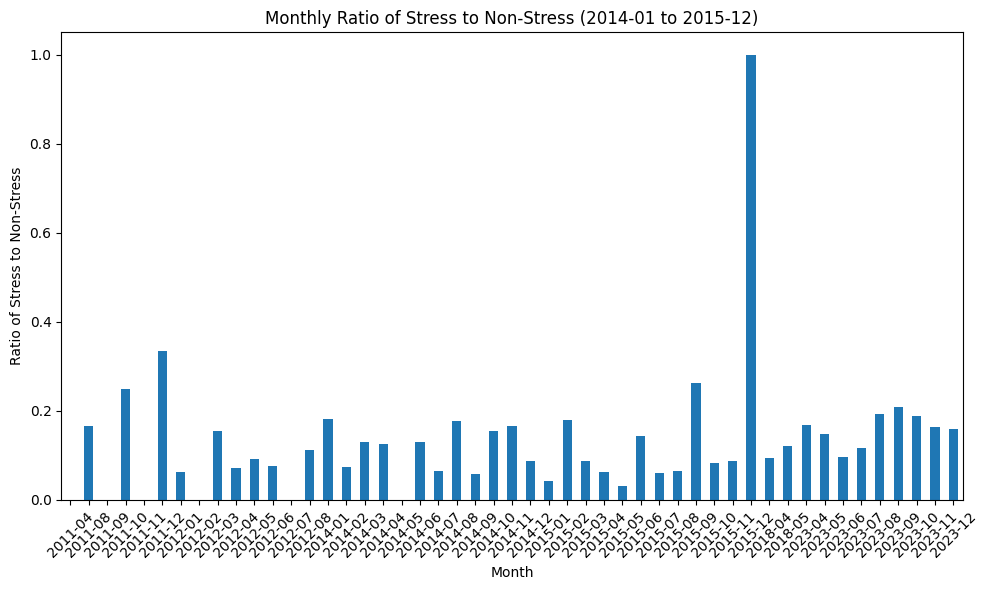

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start_date = '2014-01-01'
end_date = '2015-12-31'
filtered_df = df_sfu
#filtered_df = df_sfu[(df_sfu['created_time'] >= start_date) & (df_sfu['created_time'] <= end_date)]

# Group by the month of the 'created' date, then sum the 'stress' values
monthly_data = filtered_df.groupby(filtered_df['created_time'].dt.to_period('M')).stress.agg(['sum', 'count'])
monthly_data['non_stress'] = monthly_data['count'] - monthly_data['sum']
monthly_data['ratio'] = monthly_data['sum'] / monthly_data['non_stress']

# Reset index to convert PeriodIndex to DateTimeIndex for plotting
monthly_data.index = monthly_data.index.to_timestamp()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
monthly_data['ratio'].plot(kind='bar', ax=ax)

# Formatting the x-axis
ax.set_xlabel('Month')
ax.set_ylabel('Ratio of Stress to Non-Stress')
ax.set_title('Monthly Ratio of Stress to Non-Stress (2014-01 to 2015-12)')

# Handling x-ticks - Set major formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust x-ticks to display months within the range
ax.set_xticks(range(len(monthly_data.index)))
ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

plt.tight_layout()
plt.show()

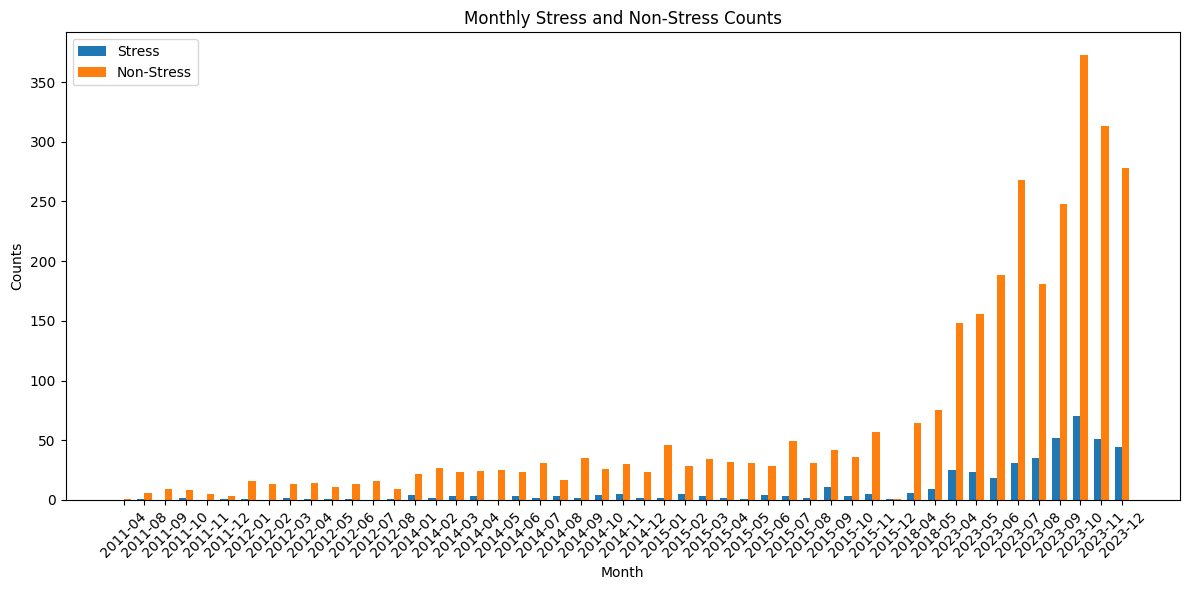

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group by month
monthly_data = df_sfu.groupby(df_sfu['created_time'].dt.to_period('M')).stress.agg(['sum', 'count'])
monthly_data['non_stress'] = monthly_data['count'] - monthly_data['sum']
monthly_data['stress'] = monthly_data['sum']  # Rename for clarity

# Reset index for plotting
monthly_data.index = monthly_data.index.to_timestamp()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Locations of the groups
ind = range(len(monthly_data))

# Bar width
width = 0.35

# Plotting both stress and non-stress
stress_bars = ax.bar(ind, monthly_data['stress'], width, label='Stress')
non_stress_bars = ax.bar([p + width for p in ind], monthly_data['non_stress'], width, label='Non-Stress')

# Formatting the plot
ax.set_xlabel('Month')
ax.set_ylabel('Counts')
ax.set_title('Monthly Stress and Non-Stress Counts')
ax.set_xticks([p + width / 2 for p in ind])
ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

#ax.set_yscale('log')

ax.legend()

plt.tight_layout()
plt.show()